# Example mean field game system solution

In [1]:
#simple direct problem solving 
import matplotlib.pyplot as plt

from clspde.solution import Solution
from clspde.basis import Basis
import itertools
import numpy as np

def prepare_model(border_weight, colloc_weight, connect_weights):
    eps = 0.005

    power = 5
    params = {
        'n_dims': 2,
        'dim_sizes': np.array([6, 6]),
        'area_lims': np.array([[0,0.1], [0,1]]),
        'power': power,
        'basis': Basis(power),
        'n_funcs': 2,
    }
    sol = Solution(**params)

    w = colloc_weight
    k1, k2 = connect_weights

    def f_collocation_points(N):
        points = np.zeros(N+1)
        h = 2/(N+1)
        points[0] = -1 + h/2
        for i in range(1, N+1):
            points[i] = points[i-1] + h
        return np.array(points).reshape(N+1,1)

    c_p_1d = f_collocation_points(power).reshape(power+1)

    colloc_points = np.array(list(itertools.product(c_p_1d, c_p_1d)))


    connect_points = np.array([[-1, 0.5], [1, 0.5],
                                [0.5, -1], [0.5, 1],
                                [-1, -0.5], [1, -0.5],
                                [-0.5, -1], [-0.5, 1],])
                                
    border_points = connect_points

    colloc_left_operators = [lambda u_loc, u_bas, x, x_loc:  (u_bas([1,0],0)-eps*u_bas([0,2],0)
                                                                                                -(u_bas([0,1],0)*u_loc([0,1],1)+
                                                                                                u_loc([0,1],0)*u_bas([0,1],1)+

                                                                                                u_loc([0,0],0)*u_bas([0,2],1)+
                                                                                                u_bas([0,0],0)*u_loc([0,2],1))
                                                                                            ) * w**2,
                            lambda u_loc, u_bas, x, x_loc:  (-u_bas([1,0],1)-eps*u_bas([0,2],1)
                                                                                                +2*(u_bas([0,1],1)*u_loc([0,1],1))
                                                                                                ) * w**2 ,]

    def popravka(f,g):
        return f*g
    colloc_right_operators = [lambda u_loc, u_nei, x, x_loc: -popravka(u_loc([0,1],0), u_loc([0,1],1)) - popravka(u_loc([0,0],0), u_loc([0,2],1)),  #2*u_loc([0,0],0)*u_loc([0,1],1)**2 * w**2, #0, 

                            lambda u_loc, u_nei, x, x_loc: (popravka(u_loc([0,1],0), u_loc([0,1],1))) * w**2]
    colloc_ops = [colloc_left_operators, colloc_right_operators]


    def initial_state(x):
        t, x = x
        sm_x = 3*x-1
        if (x<2/3 and x>1/3):
            return 3*12*sm_x**2 *(1-sm_x)
        else:
            return 0


    def terminal_state(x):
        sm_x = 3*x-1
        if (x<2/3 and x>1/3):
            return 3*12*sm_x*(1-sm_x)**2
        else:
            return 0

    small = 1e-5

    border_left_operators = [#lambda _, u_bas, x, x_loc: int(x[0]>sol.area_lims[0,0]+small)*u_bas([0,0],1) * border_weight,
                            lambda _, u_bas, x, x_loc: int(x[0]>sol.area_lims[0,0]+small)*int(x[0]<sol.area_lims[0,1]-small)*(u_bas([0,0],1)) * border_weight,
                            
                            #  lambda _, u_bas, x, x_loc: int(x[0]>sol.area_lims[0,1]-small)*(u_bas([0,0],1)-u_bas([0,0],0)) * border_weight,
                            lambda _, u_bas, x, x_loc: int(x[0]>sol.area_lims[0,1]-small)*(u_bas([0,0],1)-u_bas([0,0],0)) * border_weight,
                            
                            lambda _, u_bas, x, x_loc: int(x[0]<sol.area_lims[0,1]-small)*u_bas([0,0],0) * border_weight,
                                ]

    border_right_operators = [#lambda u, _, x, x_loc: int(x[0]>sol.area_lims[0,1]-small) * (u([0,0],0)-p(x[1])) * border_weight,
                            lambda u, _, x, x_loc: 0 * border_weight, # border condition for psi
                            
                            #   lambda u, _, x, x_loc: int(x[0]>sol.area_lims[0,1]-small) * (-terminal_state(x[1])) * border_weight, # terminal condition for psi
                            lambda u, _, x, x_loc: int(x[0]>sol.area_lims[0,1]-small) * (-terminal_state(x[1])) * border_weight, # terminal condition for psi
                            
                            lambda u, _, x, x_loc: int(x[0]<sol.area_lims[0,1]-small)*initial_state(x) * border_weight, # border and initial cond for u
                                ]
    border_ops = [border_left_operators, border_right_operators]

    def f_collocation_points(N):
        points = np.zeros(N+1)
        h = 2/(N+1)
        points[0] = -1 + h/2
        for i in range(1, N+1):
            points[i] = points[i-1] + h
        return np.array(points).reshape(N+1,1)

    # c_p_1d = f_collocation_points(int(np.ceil(power/2))).reshape(int(np.ceil(power/2))+1)

    c_p_1d = f_collocation_points(power).reshape(power+1)

    colloc_points = np.array(list(itertools.product(c_p_1d, c_p_1d)))
    connect_points = np.array([[-1, 0.5], [1, 0.5],
                                [0.5, -1], [0.5, 1],
                                [-1, -0.5], [1, -0.5],
                                [-0.5, -1], [-0.5, 1],
                                # [-1, 0], [1, 0],
                                # [0, -1], [0, 1],
                                ])
    border_points = connect_points
    points=[colloc_points, connect_points ,border_points]

    connect_left_operators = []
    connect_right_operators = []

    def dir(point: np.array) -> np.array:
        direction = (np.abs(point) == 1) * (np.sign(point))
        return np.array(direction, dtype=int)
    for func_num in range(sol.n_funcs):
        connect_left_operators += [lambda _, u_bas, x, x_loc, func_num=func_num: k1*u_bas(0*dir(x_loc),func_num) + k2*np.sum(dir(x_loc))*u_bas([0,1],func_num)]
        connect_right_operators += [lambda _, u_bas, x, x_loc, func_num=func_num: k1*u_bas(0*dir(x_loc),func_num) -  k2*np.sum(dir(x_loc))*u_bas([0,1],func_num)]
    connect_ops = [connect_left_operators, connect_right_operators]

    iteration_dict = {'points':points,
            'colloc_ops':colloc_ops,
            'border_ops':border_ops,
        'connect_ops':connect_ops
    }

    sol.cells_coefs *= 0.0
    return sol, iteration_dict

In [2]:
weights = {'border_weight':1, 
'colloc_weight':1, 
'connect_weights':[1,1]
}
sol, iteration_dict = prepare_model(**weights)
A, b = sol.solve(solver = 'SVD', **iteration_dict, verbose=True)

4.374577514139267


KeyboardInterrupt: 

In [17]:
A, b = sol.global_solve(solver = 'np', **iteration_dict, calculate = True, return_system=True, alpha = 0, verbose=True)

## Weights experiments

In [4]:
n=4
cweight_list = [2**i for i in range(n)]

bweight_list = [2**i for i in range(n)]

conditions = np.empty((n,n))

for bw, i in  zip(bweight_list, range(n)):
    for cw, j in zip(cweight_list, range(-2, n-2)):
        weights = {'border_weight':bw, 
        'colloc_weight':cw, 
        'connect_weights':[1,1]
        }
        sol, iteration_dict = prepare_model(**weights)
        A, b = sol.global_solve(solver = 'SVD', **iteration_dict, calculate = False, return_system=True, alpha = 0, verbose=True)
        conditions[i,j] = np.linalg.cond(A)

KeyboardInterrupt: 

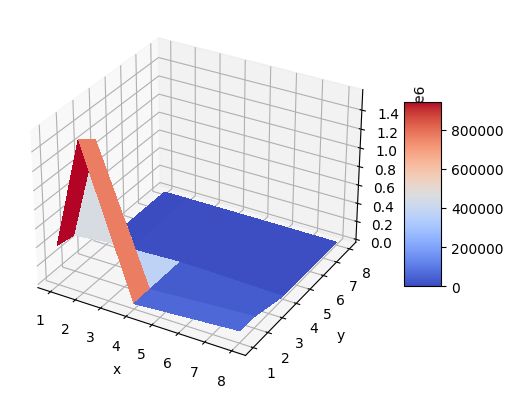

In [5]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Plot the surface.
X, Y = np.meshgrid(bweight_list, cweight_list)
surf = ax.plot_surface(X,Y,  conditions, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.xlabel('x')
plt.ylabel('y')

plt.show()

In [6]:
weights = {'border_weight':200,
'colloc_weight':1.5,
'connect_weights':np.array([200,10]) * 0.75
}
sol, iteration_dict = prepare_model(**weights)
A, b = sol.global_solve(solver = 'SVD', **iteration_dict, calculate = False, return_system=True, alpha = 0, verbose=True)
np.linalg.cond(A)

2063.431741718855

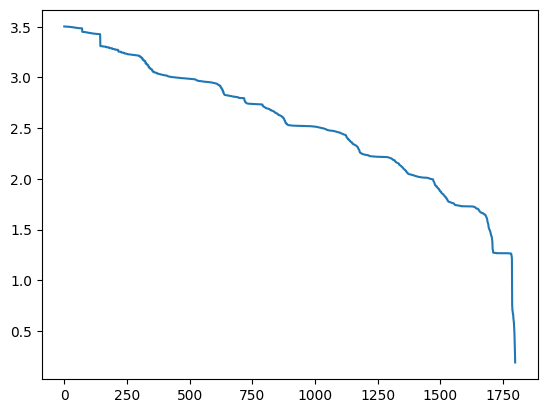

In [7]:
_, s, __ = np.linalg.svd(A)
plt.plot(np.log(s)/np.log(10))